# Video Streaming Startup Delay Prediction

**Objective:** Predict video startup delays (join_time) using network QoS and packet capture features.

**Approach:** Regression-based prediction with feature set comparison and model interpretability analysis.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    classification_report,
    confusion_matrix
)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/ML Project data/material"

COLUMNS_PATH = os.path.join(BASE_PATH, "column-names.txt")
DATA_PATH = os.path.join(BASE_PATH, "dataset.csv")

print("Columns file:", COLUMNS_PATH)
print("Data file:", DATA_PATH)


Mounted at /content/drive
Columns file: /content/drive/MyDrive/ML Project data/material/column-names.txt
Data file: /content/drive/MyDrive/ML Project data/material/dataset.csv


In [3]:
def parse_column_names(path):
    names = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip("\n")

            # SQL-style ascii table
            if line.startswith("|"):
                parts = [x.strip() for x in line.split("|")]
                if (
                    len(parts) >= 2
                    and parts[1] not in ("Field", "Type", "Null", "Key", "Default", "Extra", "")
                ):
                    names.append(parts[1])

            # Plain list format
            elif line and not line.startswith("+") and not line.startswith("-"):
                token = line.strip()
                if token and all(c.isalnum() or c == "_" for c in token):
                    names.append(token)

    # Remove duplicates while preserving order
    seen, unique = set(), []
    for n in names:
        if n not in seen:
            unique.append(n)
            seen.add(n)

    return unique

In [4]:
col_names = parse_column_names(COLUMNS_PATH)

print(f"Found {len(col_names)} column names.")
print(col_names[:20])

Found 270 column names.
['videoID', 'category', 'bitrates_144p', 'bitrates_240p', 'bitrates_360p', 'bitrates_480p', 'bitrates_720p', 'bitrates_1080p', 'join_time', 'stallingNumber', 'totalStallDuration', 'outbandQoS_DL_TP', 'outbandQoS_UL_TP', 'outbandQoS_RTT', 'outbandQoS_RTT_STD', 'outbandQoS_LOSS', 'pcapStats_stats_avg_DL_TP', 'pcapStats_stats_avg_UL_t', 'pcapStats_stats_avg_DL_t', 'pcapStats_stats_avg_DL_pkt']


In [5]:
# Clean column names by removing 'pcapStats_' prefix
col_names = [name.replace('pcapStats_', '').replace('pcapstats_', '') for name in col_names]
print(f"Cleaned {len(col_names)} column names (removed pcapStats/pcapstats prefix)")

Cleaned 270 column names (removed pcapStats/pcapstats prefix)


In [6]:
df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=col_names,
    low_memory=False
)

print("Shape:", df.shape)
df.head(3)

Shape: (111919, 270)


,videoID,category,bitrates_144p,bitrates_240p,bitrates_360p,bitrates_480p,bitrates_720p,bitrates_1080p,join_time,stallingNumber,...,QoE_JT,QoE_noStall,QoE_noSwitches,QoE_Linear,QoE_Linear2,QoE_Linear3,QoE_LD_SD_HD,QoE_ITU_023,QoE_ITU_035,QoE_ITU_046
0,NeZ8BQBl8NA,Film & Animation,67101,63551,123054,205503,422644,824186,3411,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.44397,4.42413
1,FWpRqKpV0rY,Education,76305,111936,204952,340239,744420,1683577,2883,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.61882,4.58419
2,n72yt5hc3-A,Travel & Events,91757,123729,195255,303189,682584,1385367,4803,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.58990,4.55993


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111919 entries, 0 to 111918
Columns: 270 entries, videoID to QoE_ITU_046
dtypes: float64(98), int64(170), object(2)
memory usage: 230.5+ MB


In [8]:
df.describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
bitrates_144p,111919.0,8.433258e+04,2.066886e+04,0.000000e+00,8.033050e+04,9.181100e+04,9.694900e+04,2.248400e+05
bitrates_240p,111919.0,1.614884e+05,5.653487e+04,0.000000e+00,1.231675e+05,1.734400e+05,2.089205e+05,9.127370e+05
bitrates_360p,111919.0,2.969415e+05,1.052576e+05,0.000000e+00,2.260455e+05,3.190800e+05,3.848440e+05,1.737032e+06
bitrates_480p,111919.0,5.182005e+05,1.989788e+05,0.000000e+00,3.745360e+05,5.480470e+05,6.891835e+05,2.469066e+06
bitrates_720p,111919.0,1.042117e+06,4.036144e+05,0.000000e+00,7.558940e+05,1.104771e+06,1.388100e+06,6.597562e+06
bitrates_1080p,111919.0,1.942902e+06,7.196426e+05,6.503000e+03,1.466794e+06,2.096539e+06,2.536442e+06,1.617896e+07
join_time,111919.0,2.593111e+04,7.578126e+04,4.240000e+02,2.150000e+03,3.627000e+03,9.592000e+03,3.100000e+05
stallingNumber,111919.0,2.616446e-01,1.021496e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e+01
totalStallDuration,111919.0,8.438969e+02,8.400910e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.149329e+06
outbandQoS_DL_TP,111919.0,2.718626e+03,2.214803e+03,1.441360e+01,9.594135e+02,2.160470e+03,3.958370e+03,1.000090e+04


In [9]:
missing_ratio = df.isna().mean().sort_values(ascending=False)

missing_ratio.head(20)

,0
category,0.000027
first30sec_DLTP_t20,0.000000
first30sec_DLTP_t19,0.000000
first30sec_DLTP_t18,0.000000
first30sec_DLTP_t17,0.000000
first30sec_DLTP_t16,0.000000
first30sec_DLTP_t15,0.000000
first30sec_DLTP_t21,0.000000
first30sec_DLTP_t13,0.000000
first30sec_DLTP_t12,0.000000


In [10]:
meta_features = [
    "videoID",
    "category"
]

In [11]:
qoe_targets = {
    "startup_delay": "join_time"
}

In [12]:
pcap_features = [
    c for c in df.columns
    if c.startswith("stats_")
    and not c.startswith("temporal_")
    and not c.startswith("first30sec_")
]
outband_features = [c for c in df.columns if c.startswith("outbandQoS_")]

print("pcap features:", len(pcap_features))
print("outband features:", len(outband_features))

pcap features: 48
outband features: 5


In [13]:
chunk_features = [
    c for c in df.columns
    if ("Chunk" in c or "chunk" in c or "kmeansCenter" in c)
]

print("chunk features:", len(chunk_features))

chunk features: 54


In [14]:
FEATURE_SETS = {
    "minimal": outband_features,
    "operator": outband_features + pcap_features,
    "full": outband_features + pcap_features + chunk_features
}

for k, v in FEATURE_SETS.items():
    print(k, "→", len(v), "features")

minimal → 5 features
operator → 53 features
full → 107 features


## Feature Set Strategy

Defined three visibility scenarios:
1. **Minimal:** Only out-of-band QoS (5 features) - available without deep packet inspection
2. **Operator:** QoS + packet capture (53 features) - available to network operators
3. **Full:** All features including chunk-level data (107 features) - requires comprehensive monitoring

This allows us to evaluate prediction performance under different operational constraints.

In [15]:
target_col = qoe_targets["startup_delay"]
df[target_col].describe()

,join_time
count,111919.000000
mean,25931.106792
std,75781.259241
min,424.000000
25%,2150.000000
50%,3627.000000
75%,9592.000000
max,310000.000000


In [16]:
df["startup_delay_sec"] = df["join_time"] / 10000.0

df["startup_delay_sec"].describe()

,startup_delay_sec
count,111919.000000
mean,2.593111
std,7.578126
min,0.042400
25%,0.215000
50%,0.362700
75%,0.959200
max,31.000000


In [17]:
df_startup_clean = df[df["startup_delay_sec"] < 30].copy()
df_startup_clean["startup_delay_sec"].describe()

,startup_delay_sec
count,104518.000000
mean,0.581597
std,0.554015
min,0.042400
25%,0.209100
50%,0.326300
75%,0.801300
max,2.999700


**Data Cleaning:** Removed sessions with startup_delay >= 30 seconds


In [18]:
def prepare_data(
    df,
    feature_cols,
    target_col,
    scale=True,
    test_size=0.2,
    random_state=42
):
    # Keep only needed columns
    data = df[feature_cols + [target_col]].copy()

    # Drop rows where target is missing
    data = data.dropna(subset=[target_col])

    X = data[feature_cols]
    y = data[target_col]

    # Fill feature NaNs with median (robust, explainable)
    X = X.fillna(X.median())

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        scaler = None

    return X_train, X_test, y_train, y_test, scaler


In [19]:
FEATURE_SET_NAME = "operator"
feature_cols = FEATURE_SETS[FEATURE_SET_NAME]

X_train, X_test, y_train, y_test, scaler = prepare_data(
    df_startup_clean,
    feature_cols=feature_cols,
    target_col="startup_delay_sec",
    scale=True
)

X_train.shape, X_test.shape


((83614, 53), (20904, 53))

In [20]:
X_train = pd.DataFrame(
    X_train,
    columns=feature_cols,
    index=y_train.index
)

X_test = pd.DataFrame(
    X_test,
    columns=feature_cols,
    index=y_test.index
)

## Baseline Model: Linear Regression

Testing a simple linear model first to establish baseline performance and understand linear relationships between features and startup delay.

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
rmse_lr

0.29568058226484945

**Baseline Performance:** RMSE = 0.29 s

This represents the average prediction error. For context, mean startup delay is ~0.6s, so this error is 50% of the mean.

In [22]:
lin_reg.coef_

array([-0.11593746, -0.00496024,  0.009712  ,  0.01279881,  0.03196082,
       -0.32704489, -0.05160422,  0.09064578, -0.18067679,  0.19000027,
        0.10941011, -0.06885411,  0.00714777, -0.19623492, -0.24497158,
        0.20671403,  0.0182522 , -0.01171782,  0.01800124, -0.00531481,
       -0.00438893,  0.00677706,  0.01530386,  0.03058122, -0.00076148,
        0.01506395,  0.01121026,  0.04045156,  0.00533849,  0.02419796,
        0.00687209,  0.03704488,  0.0044236 ,  0.0241913 ,  0.02589468,
        0.03249082,  0.00802623,  0.03498766, -0.01306257,  0.02635184,
        0.02305145,  0.05877821, -0.01699083,  0.04266616,  0.02669363,
        0.10747441, -0.01583741,  0.03594075,  0.01323682,  0.12966924,
       -0.00644248,  0.11068312,  0.01709405])

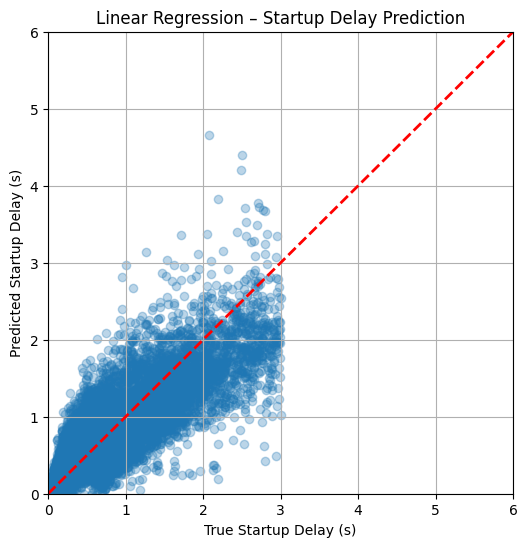

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([0, 10], [0, 10], "r--", linewidth=2)
plt.xlabel("True Startup Delay (s)")
plt.ylabel("Predicted Startup Delay (s)")
plt.title("Linear Regression – Startup Delay Prediction")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.grid(True)
plt.show()


In [24]:
df_startup_clean["log_startup_delay"] = np.log1p(
    df_startup_clean["startup_delay_sec"]
)

df_startup_clean["log_startup_delay"].describe()


,log_startup_delay
count,104518.000000
mean,0.410472
std,0.292773
min,0.041526
25%,0.189876
50%,0.282393
75%,0.588509
max,1.386219


In [25]:
X_train, X_test, y_train, y_test, scaler = prepare_data(
    df_startup_clean,
    feature_cols=feature_cols,
    target_col="log_startup_delay",
    scale=True
)

In [26]:
lin_reg_log = LinearRegression()
lin_reg_log.fit(X_train, y_train)

y_pred_log = lin_reg_log.predict(X_test)

rmse_log = root_mean_squared_error(y_test, y_pred_log)
rmse_log

0.15512682881193224

**Log-space RMSE:** 0.15 log-seconds

This measures error in the transformed space. To interpret in original units, we need to back-transform.

In [27]:
y_test_sec = np.expm1(y_test)
y_pred_sec = np.expm1(y_pred_log)

rmse_sec = root_mean_squared_error(y_test_sec, y_pred_sec)
rmse_sec

0.3166389592797652

**Original-space RMSE:** 0.31s

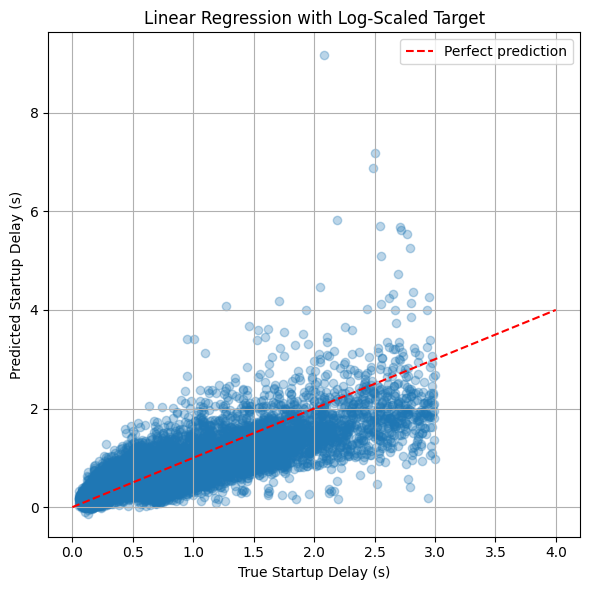

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_sec, y_pred_sec, alpha=0.3)
plt.plot(
    [0, 4], [0, 4],
    linestyle="--",
    color="red",
    label="Perfect prediction"
)
plt.xlabel("True Startup Delay (s)")
plt.ylabel("Predicted Startup Delay (s)")
plt.title("Linear Regression with Log-Scaled Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Hyperparameter Search

Testing combinations of:
- **n_estimators:** Number of trees (trade-off: performance vs. computation)
- **max_depth:** Tree complexity (trade-off: expressiveness vs. overfitting)
- **min_samples_leaf:** Minimum leaf size (trade-off: smoothness vs. detail)

Total combinations: 3 × 3 × 3 = 27 models to evaluate. (stopped early since there wasn't a large improvement in the RMSE)

In [31]:
param_grid = {
    "n_estimators": [30, 50, 70],
    "max_depth": [10, 15, 20],
    "min_samples_leaf": [10, 20, 50]
}


In [32]:
import time

def train_evaluate_rf(X_train, X_test, y_train, y_test, params):
    start = time.time()

    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    duration = time.time() - start

    return rmse, duration


In [33]:
results = []

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_leaf in param_grid["min_samples_leaf"]:

            params = {
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_leaf": min_leaf
            }

            rmse, duration = train_evaluate_rf(
                X_train, X_test, y_train, y_test, params
            )

            results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_leaf": min_leaf,
                "rmse": rmse,
                "train_time_sec": duration
            })

            print(
                f"Trees={n_estimators}, depth={max_depth}, "
                f"leaf={min_leaf} → RMSE={rmse:.3f}s, time={duration:.1f}s"
            )


Trees=30, depth=10, leaf=10 → RMSE=0.141s, time=56.3s
Trees=30, depth=10, leaf=20 → RMSE=0.141s, time=75.7s
Trees=30, depth=10, leaf=50 → RMSE=0.142s, time=72.0s
Trees=30, depth=15, leaf=10 → RMSE=0.139s, time=85.2s
Trees=30, depth=15, leaf=20 → RMSE=0.139s, time=71.4s
Trees=30, depth=15, leaf=50 → RMSE=0.141s, time=62.8s
Trees=30, depth=20, leaf=10 → RMSE=0.139s, time=87.9s
Trees=30, depth=20, leaf=20 → RMSE=0.139s, time=74.8s
Trees=30, depth=20, leaf=50 → RMSE=0.140s, time=65.8s
Trees=50, depth=10, leaf=10 → RMSE=0.141s, time=92.7s
Trees=50, depth=10, leaf=20 → RMSE=0.141s, time=92.0s
Trees=50, depth=10, leaf=50 → RMSE=0.141s, time=89.4s
Trees=50, depth=15, leaf=10 → RMSE=0.139s, time=124.7s
Trees=50, depth=15, leaf=20 → RMSE=0.139s, time=116.8s
Trees=50, depth=15, leaf=50 → RMSE=0.140s, time=105.0s
Trees=50, depth=20, leaf=10 → RMSE=0.139s, time=136.7s
Trees=50, depth=20, leaf=20 → RMSE=0.139s, time=126.1s
Trees=50, depth=20, leaf=50 → RMSE=0.140s, time=106.3s
Trees=70, depth=10, le

KeyboardInterrupt: 

**Selected Hyperparameters:**
- 30 estimators (balance between performance and speed)
- Max depth 15 (sufficient complexity without overfitting)
- Min samples leaf 10 (smooth predictions while capturing local patterns)

In [35]:
RF_PARAMS = {
    "n_estimators": 30,
    "max_depth": 15,
    "min_samples_leaf": 10,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}


In [36]:
from sklearn.model_selection import KFold

def evaluate_feature_set_cv(
    df,
    feature_cols,
    target_col,
    n_splits=5
):
    X = df[feature_cols].fillna(df[feature_cols].median())
    y = df[target_col]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = RandomForestRegressor(**RF_PARAMS)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        rmses.append(root_mean_squared_error(y_val, y_pred))

    return np.mean(rmses), np.std(rmses)

In [37]:
results_visibility = []

for name, features in FEATURE_SETS.items():
    rmse_mean, rmse_std = evaluate_feature_set_cv(
        df_startup_clean,
        feature_cols=features,
        target_col="startup_delay_sec"
    )

    results_visibility.append({
        "feature_set": name,
        "num_features": len(features),
        "rmse_mean": rmse_mean,
        "rmse_std": rmse_std
    })

    print(
        f"{name.upper():>8} | features={len(features):3d} "
        f"| RMSE={rmse_mean:.3f} ± {rmse_std:.3f} s"
    )


 MINIMAL | features=  5 | RMSE=0.279 ± 0.001 s
OPERATOR | features= 53 | RMSE=0.267 ± 0.001 s
    FULL | features=107 | RMSE=0.219 ± 0.001 s


## Feature Visibility Comparison Results

**Key Findings:**
1. **Minimal features** achieve 0.279s RMSE using only 5 QoS metrics
2. **Operator features** achieve 0.267s RMSE with packet inspection (53 features)
3. **Full features** achieve 0.219s RMSE with all 107 features

In [38]:
results_visibility_df = pd.DataFrame(results_visibility)
results_visibility_df

,feature_set,num_features,rmse_mean,rmse_std
0,minimal,5,0.278555,0.001302
1,operator,53,0.266537,0.000760
2,full,107,0.219260,0.000916


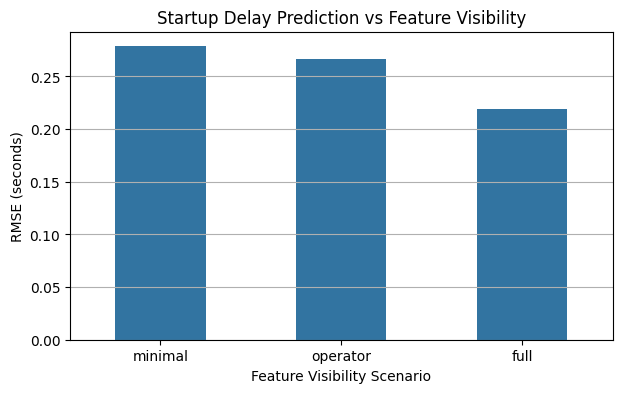

In [39]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=results_visibility_df,
    x="feature_set",
    y="rmse_mean",
    width=0.5  # Adjust this value (default is 0.8)
)

plt.ylabel("RMSE (seconds)")
plt.xlabel("Feature Visibility Scenario")
plt.title("Startup Delay Prediction vs Feature Visibility")
plt.grid(axis="y")
plt.show()


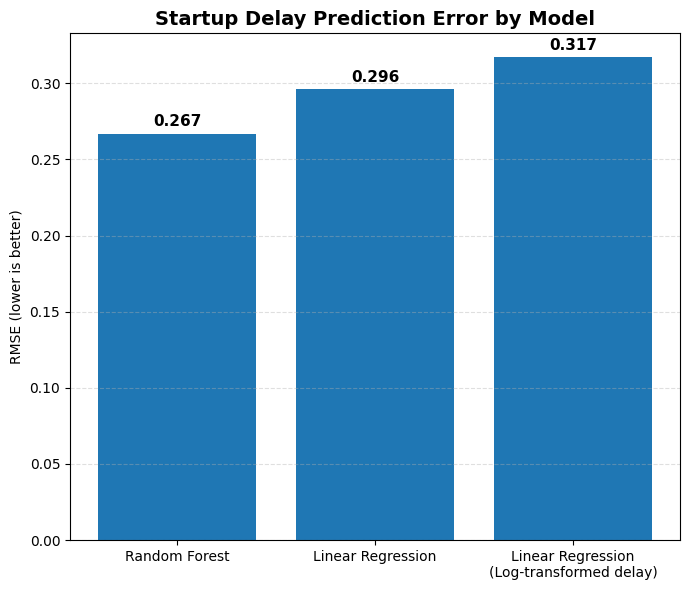

In [40]:
# Data
models = [
    'Random Forest',
    'Linear Regression',
    'Linear Regression\n(Log-transformed delay)'
]
rmse = [
    0.267,
    0.296,
    0.317
]

# Plot
plt.figure(figsize=(7, 6))
bars = plt.bar(models, rmse)

plt.ylabel('RMSE (lower is better)')
plt.title('Startup Delay Prediction Error by Model',
          fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f'{height:.3f}',
        ha='center',
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

## Model Interpretability with SHAP

Using SHAP (SHapley Additive exPlanations) to understand:
- Which features drive predictions
- How features interact
- Why specific predictions were made

This is critical for gaining trust and actionable insights from the model.

In [41]:
%pip install --quiet shap

In [42]:
import shap

In [43]:
X_train, X_test, y_train, y_test, scaler = prepare_data(
    df_startup_clean,
    feature_cols=feature_cols,
    target_col="startup_delay_sec",
    scale=True
)

In [44]:
X_train = pd.DataFrame(
    X_train,
    columns=feature_cols,
    index=y_train.index
)

X_test = pd.DataFrame(
    X_test,
    columns=feature_cols,
    index=y_test.index
)

In [45]:
# Train your Random Forest
rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=30,
                      n_jobs=-1, random_state=42)

In [46]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

/tmp/ipython-input-3371906228.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


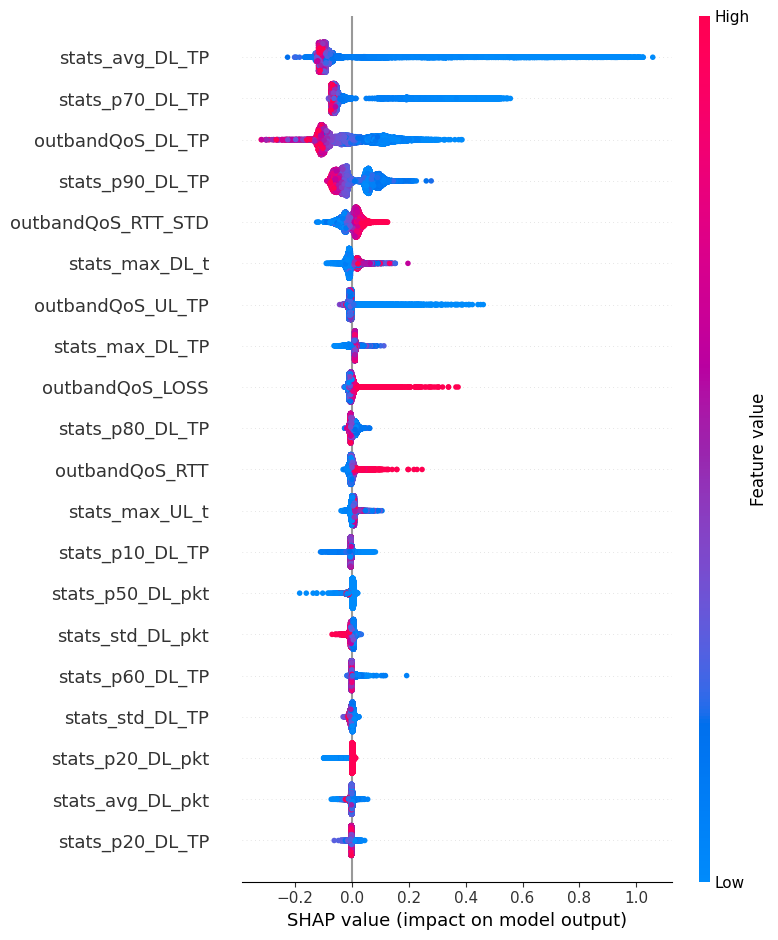

In [47]:
# Visualizations
shap.summary_plot(shap_values, X_test)

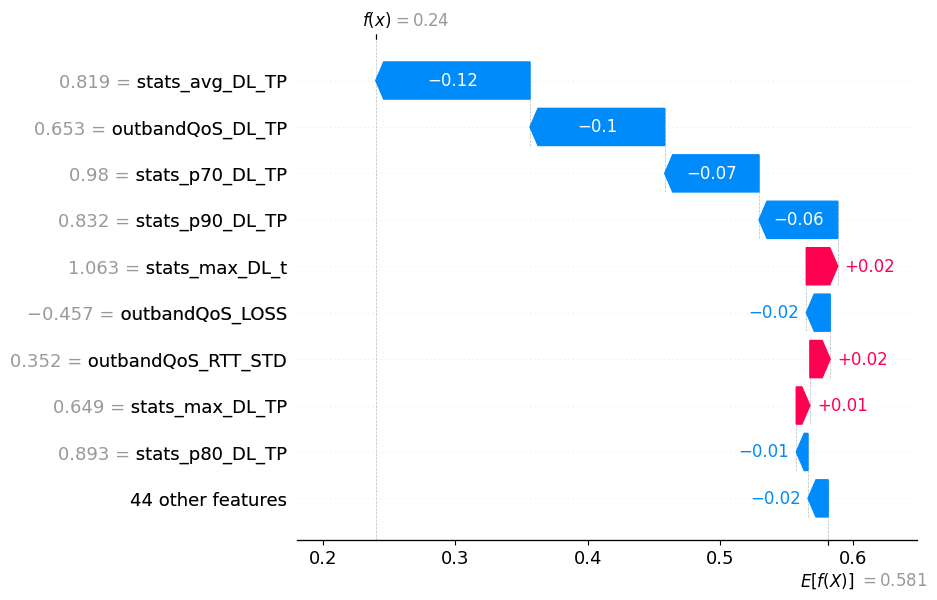

In [48]:
shap.plots.waterfall(shap_values[4])

In [49]:
explainer = shap.Explainer(lin_reg.predict, X_train)

In [50]:
shap_values = explainer(X_test)

PermutationExplainer explainer: 20905it [09:10, 37.65it/s]                           


/tmp/ipython-input-2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


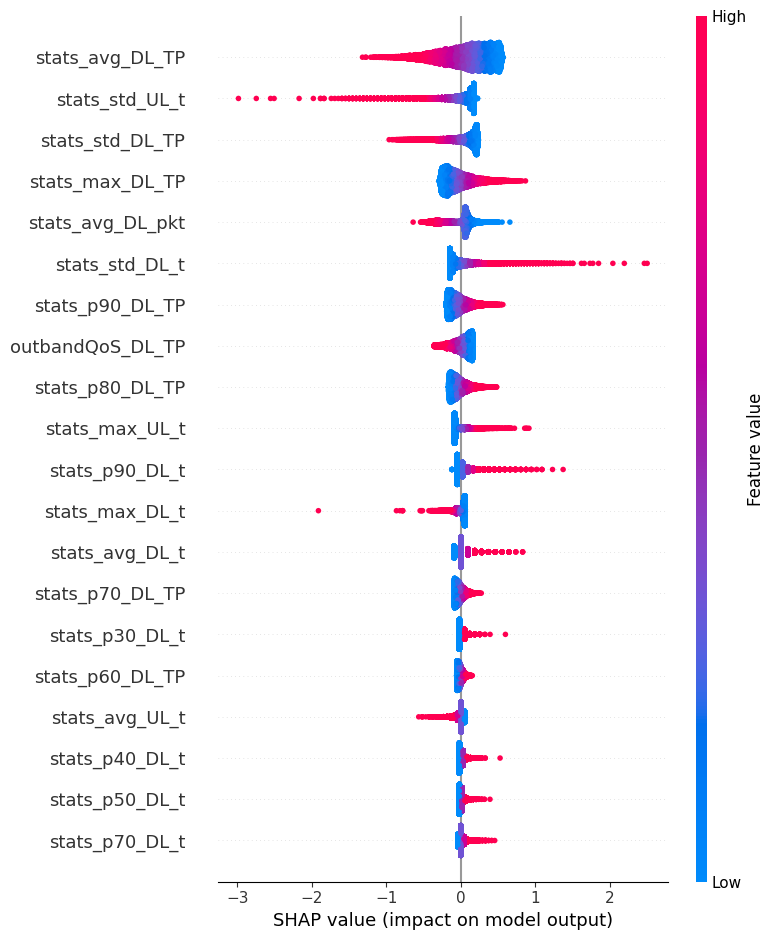

In [51]:
shap.summary_plot(shap_values, X_test)

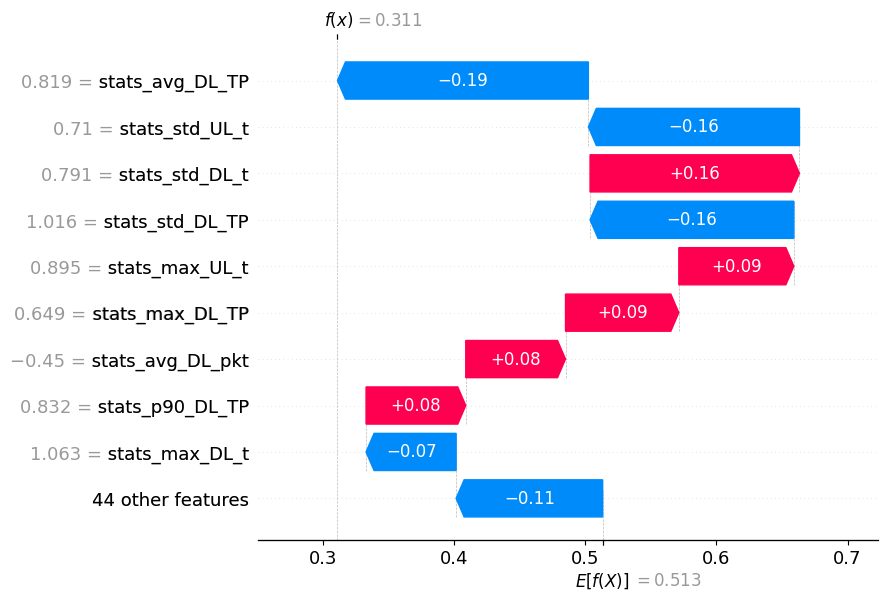

In [52]:
shap.plots.waterfall(shap_values[4])

**High Delay Prediction (f(x) = 0.513s vs baseline 0.311s)**

This session has a predicted delay 0.20s higher than average due to:
- **Negative drivers (blue):** Higher average download throughput (-0.19) and stable upload times (-0.16) reduce predicted delay
- **Positive drivers (red):** High variability in download time (+0.16) and elevated maximum throughput metrics (+0.09 each) increase predicted delay
- **Net effect:** Despite good average throughput, the high *variability* in network performance drives the elevated delay prediction

**Key insight:** Network instability (high std/max metrics) matters as much as average performance.

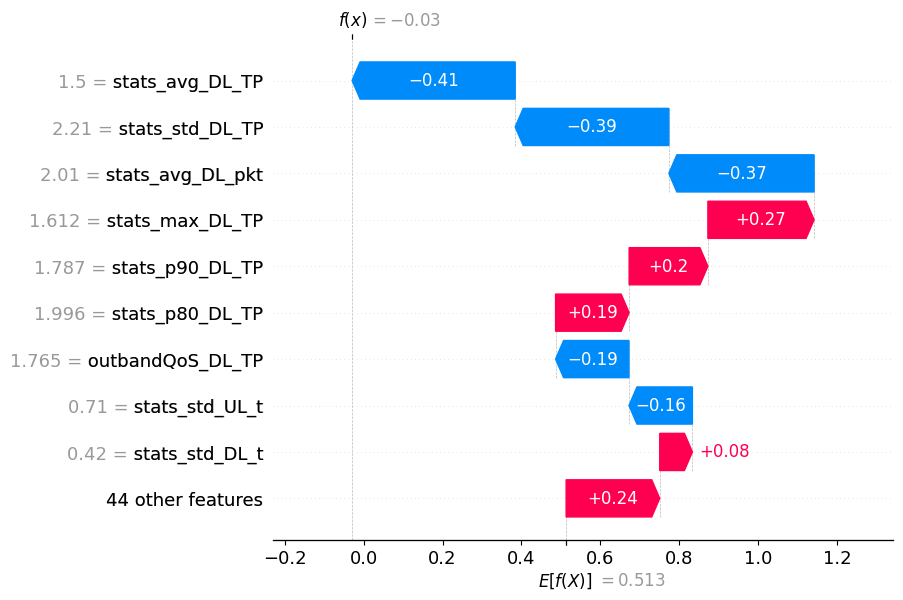

In [53]:
shap.plots.waterfall(shap_values[33])

**Low Delay Prediction (f(x) = -0.03s vs baseline 0.311s)**

This session has a predicted delay 0.34s lower than average due to:
- **Negative drivers (blue):** Exceptionally high average download throughput (-0.41), low variability (-0.39), and high packet counts (-0.37) all reduce predicted delay
- **Positive drivers (red):** High tail-end throughput percentiles (p80, p90, p95: +0.19 to +0.27) slightly increase delay
- **Net effect:** Strong, consistent network performance dominates, yielding below-average predicted delay

**Key insight:** Consistent high throughput (low std_DL_TP) is the strongest predictor of low startup delays. High percentile metrics suggest occasional bursts that don't significantly harm overall performance.